In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

#Xsc=np.load('/content/drive/MyDrive/데이터셋/Xsc.npy')
#Xcr=np.load('/content/drive/MyDrive/데이터셋/Xcr.npy')
#Xse=np.load('/content/drive/MyDrive/데이터셋/Xse.npy')
Xbr=np.load('/content/drive/MyDrive/데이터셋/Xbr.npy')
#Ysc=np.load('/content/drive/MyDrive/데이터셋/Ysc.npy')
#Ycr=np.load('/content/drive/MyDrive/데이터셋/Ycr.npy')
#Yse=np.load('/content/drive/MyDrive/데이터셋/Yse.npy')
Ybr=np.load('/content/drive/MyDrive/데이터셋/Ybr.npy')

# 차량탐지, 배경 없애기 작업
## why? 일반화 성능 개선
### 배경을 아예 없애(검정)버린다면? >> 실제 환경과 달라서 성능 저하
### 배경을 그대로 살려둔다면? >> 특정 배경에 과적합 가능
### 배경을 블러처리 또는 배경을 제외하고 선명하게 처리
###YOLOv3 모델이 차량의 부위보다는 전체적 외형을 잘 탐지하는 특성을 이용하여 비교적 멀리서 촬영된 사진들의 차량부분은 선명하게, 배경 부분은 블러처리할 것이다. 가까이서 찍힌 사진들은 배경이 거의 사진에 없으므로 탐지 못되어도 괜찮다고 생각한다.

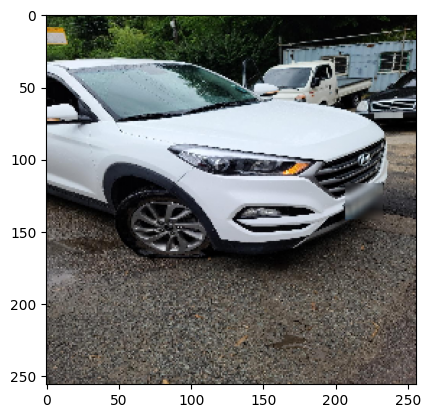

In [ ]:
# 원본 이미지
import matplotlib.pyplot as plt
plt.imshow(Xbr[12])

## 배경 블러처리

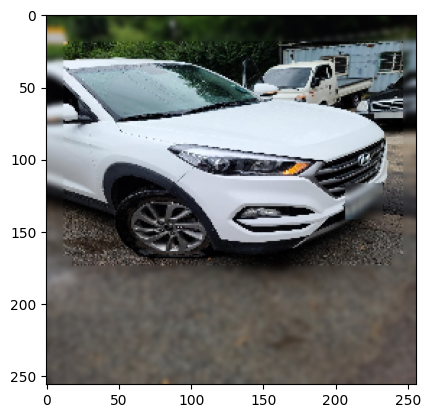

In [ ]:
import cv2

# YOLO 모델 로드
net = cv2.dnn.readNet('/content/drive/MyDrive/yolo/yolov3.weights', '/content/drive/MyDrive/yolo/yolov3.cfg')
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]


# 이미지 로드
img = Xbr[12]
height, width, channels = img.shape

if img.dtype != np.uint8:
    img=img*255
    img = img.astype(np.uint8)

# 객체 탐지 수행
blob = cv2.dnn.blobFromImage(img, 0.00392, (256, 256), (0, 0, 0), swapRB=True)
net.setInput(blob)
outs = net.forward(output_layers)

# 탐지된 객체 정보 추출
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # 객체 위치 계산
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # 바운딩 박스 계산
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)




# 배경 블러 처리
blurred_img = cv2.GaussianBlur(img, (9, 9), 0)
for i in range(len(boxes)):
    if class_ids[i] == 2:  # '차량' 클래스의 ID
        x, y, w, h = boxes[i]
        roi = img[y:y+h, x:x+w]
        blurred_img[y:y+h, x:x+w] = roi

# 이미지 표시
plt.imshow(blurred_img)
plt.show()

In [ ]:
# 셋 생성

Xbr_new = []  # 전처리된 이미지를 저장할 새 배열

for img in Xbr:
    # 이미지 크기 및 유형 조정
    height, width, channels = img.shape
    if img.dtype != np.uint8:
        img = img * 255
        img = img.astype(np.uint8)

    # 객체 탐지 수행
    blob = cv2.dnn.blobFromImage(img, 0.00392, (256, 256), (0, 0, 0), swapRB=True)
    net.setInput(blob)
    outs = net.forward(output_layers)

     # 탐지된 객체 정보 추출
    class_ids = []
    confidences = []
    boxes = []
    car_detected = False  # 차량 탐지 여부
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # 객체 위치 계산
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # 바운딩 박스 계산
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                if class_id == 2:  # '차량' 클래스의 ID (ID 번호에 따라 조정 필요)
                    car_detected = True

    # 차량 객체가 탐지된 경우에만 배경 블러 처리
    if car_detected:
        blurred_img = cv2.GaussianBlur(img, (9, 9), 0)
        for i in range(len(boxes)):
            if class_ids[i] == 2:  # '차량' 클래스의 ID
                x, y, w, h = boxes[i]
                roi = img[y:y+h, x:x+w]
                blurred_img[y:y+h, x:x+w] = roi
        img = blurred_img

    # 전처리된 이미지를 배열에 추가
    Xbr_new.append(img)

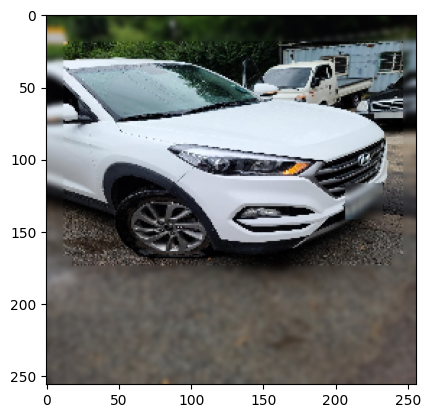

In [ ]:
plt.imshow(Xbr_new[12])

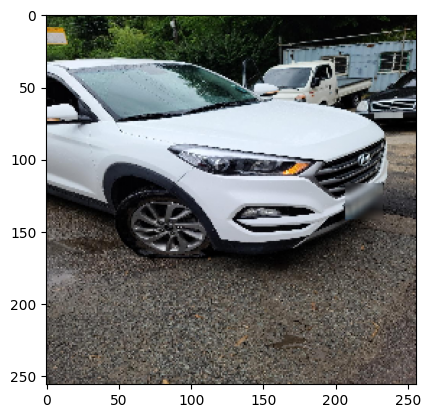

In [ ]:
plt.imshow(Xbr[12])

## 차량만 선명하게 처리

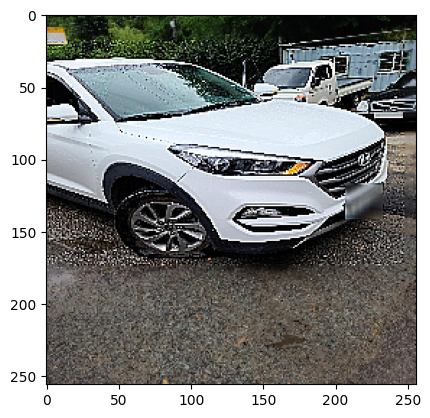

In [ ]:
# YOLO 모델 로드
net = cv2.dnn.readNet('/content/drive/MyDrive/yolo/yolov3.weights', '/content/drive/MyDrive/yolo/yolov3.cfg')
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]


# 이미지 로드
img = Xbr[12]
height, width, channels = img.shape

if img.dtype != np.uint8:
    img=img*255
    img = img.astype(np.uint8)

# 객체 탐지 수행
blob = cv2.dnn.blobFromImage(img, 0.00392, (256, 256), (0, 0, 0), swapRB=True)
net.setInput(blob)
outs = net.forward(output_layers)

# 탐지된 객체 정보 추출
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # 객체 위치 계산
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # 바운딩 박스 계산
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)



# 이미지 표시
plt.imshow(img)
#cv2_imshow(img)


sharpening_kernel = np.array([[-0.25, -0.25, -0.25],
                              [-0.25, 3, -0.25],
                              [-0.25, -0.25, -0.25]])

# 객체만 샤프닝 처리
sharpened_img = img.copy()
for i in range(len(boxes)):
    if class_ids[i] == 2:  # '차량' 클래스의 ID
        x, y, w, h = boxes[i]

        # ROI가 이미지 경계 내에 있는지 확인
        x, y, w, h = max(0, x), max(0, y), min(w, width - x), min(h, height - y)

        roi = img[y:y+h, x:x+w]

        # ROI가 비어 있지 않은 경우에만 샤프닝 적용
        if roi.size != 0:
            sharpened_roi = cv2.filter2D(roi, -1, sharpening_kernel)
            sharpened_img[y:y+h, x:x+w] = sharpened_roi

# 이미지 표시
plt.imshow(sharpened_img)
plt.show()

In [ ]:
# 셋 생성

Xbr_new2 = []  # 전처리된 이미지를 저장할 새 배열

sharpening_kernel = np.array([[-0.25, -0.25, -0.25],
                            [-0.25, 3, -0.25],
                            [-0.25, -0.25, -0.25]])

for img in Xbr:
    # 이미지 크기 및 유형 조정
    height, width, channels = img.shape
    if img.dtype != np.uint8:
        img = img * 255
        img = img.astype(np.uint8)

    # 객체 탐지 수행
    blob = cv2.dnn.blobFromImage(img, 0.00392, (256, 256), (0, 0, 0), swapRB=True)
    net.setInput(blob)
    outs = net.forward(output_layers)

     # 탐지된 객체 정보 추출
    class_ids = []
    confidences = []
    boxes = []
    car_detected = False  # 차량 탐지 여부
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # 객체 위치 계산
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # 바운딩 박스 계산
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                if class_id == 2:  # '차량' 클래스의 ID (ID 번호에 따라 조정 필요)
                    car_detected = True


    sharpened_img = img.copy()
    if car_detected:
      for i in range(len(boxes)):
        if class_ids[i] == 2:  # '차량' 클래스의 ID
            x, y, w, h = boxes[i]

            # ROI가 이미지 경계 내에 있는지 확인
            x, y, w, h = max(0, x), max(0, y), min(w, width - x), min(h, height - y)

            roi = img[y:y+h, x:x+w]

            # ROI가 비어 있지 않은 경우에만 샤프닝 적용
            if roi.size != 0:
                sharpened_roi = cv2.filter2D(roi, -1, sharpening_kernel)
                sharpened_img[y:y+h, x:x+w] = sharpened_roi

    # 전처리된 이미지를 배열에 추가
    Xbr_new2.append(sharpened_img)

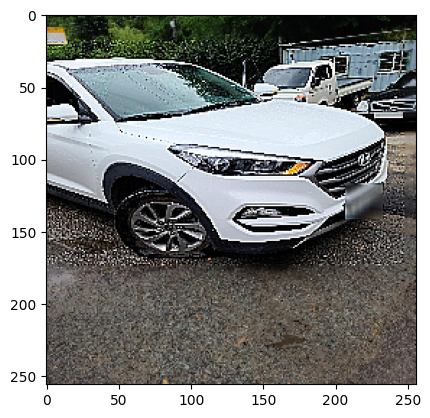

In [ ]:
plt.imshow(Xbr_new2[12])

In [ ]:
len(Xbr_new2)

1045

# 블러+선명하게

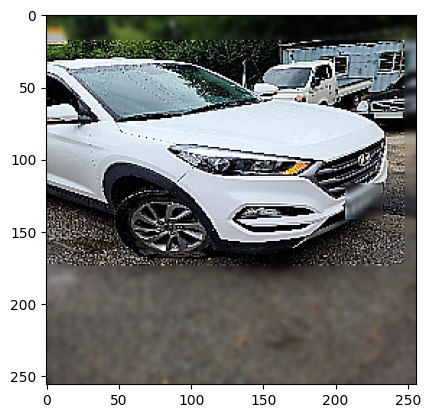

In [ ]:
# YOLO 모델 로드
net = cv2.dnn.readNet('/content/drive/MyDrive/yolo/yolov3.weights', '/content/drive/MyDrive/yolo/yolov3.cfg')
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]


# 이미지 로드
img = Xbr[12]
height, width, channels = img.shape

if img.dtype != np.uint8:
    img=img*255
    img = img.astype(np.uint8)

# 객체 탐지 수행
blob = cv2.dnn.blobFromImage(img, 0.00392, (256, 256), (0, 0, 0), swapRB=True)
net.setInput(blob)
outs = net.forward(output_layers)

# 탐지된 객체 정보 추출
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # 객체 위치 계산
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # 바운딩 박스 계산
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)



sharpening_kernel = np.array([[-0.25, -0.25, -0.25],
                              [-0.25, 3, -0.25],
                              [-0.25, -0.25, -0.25]])

# 배경 블러 처리
blurred_img = cv2.GaussianBlur(img, (9, 9), 0)
for i in range(len(boxes)):
    if class_ids[i] == 2:  # '차량' 클래스의 ID
        x, y, w, h = boxes[i]
        roi = img[y:y+h, x:x+w]
        blurred_img[y:y+h, x:x+w] = roi

# 객체만 샤프닝 처리
sharpened_img = blurred_img.copy()
for i in range(len(boxes)):
    if class_ids[i] == 2:  # '차량' 클래스의 ID
        x, y, w, h = boxes[i]

        # ROI가 이미지 경계 내에 있는지 확인
        x, y, w, h = max(0, x), max(0, y), min(w, width - x), min(h, height - y)

        roi = img[y:y+h, x:x+w]

        # ROI가 비어 있지 않은 경우에만 샤프닝 적용
        if roi.size != 0:
            sharpened_roi = cv2.filter2D(roi, -1, sharpening_kernel)
            sharpened_img[y:y+h, x:x+w] = sharpened_roi

# 이미지 표시
plt.imshow(sharpened_img)
plt.show()

In [ ]:
# 셋 생성

Xbr_processed = []  # 처리된 이미지를 저장할 배열

# 샤프닝 커널 정의
sharpening_kernel = np.array([[-0.25, -0.25, -0.25],
                              [-0.25, 3, -0.25],
                              [-0.25, -0.25, -0.25]])

for img in Xbr:
    # 이미지 크기 및 유형 조정
    height, width, channels = img.shape
    if img.dtype != np.uint8:
        img = img * 255
        img = img.astype(np.uint8)

    # 객체 탐지 수행
    blob = cv2.dnn.blobFromImage(img, 0.00392, (256, 256), (0, 0, 0), swapRB=True)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # 탐지된 객체 정보 추출
    class_ids = []
    confidences = []
    boxes = []
    car_detected = False
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # 객체 위치 계산
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # 바운딩 박스 계산
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                if class_id == 2:  # '차량' 클래스의 ID
                    car_detected = True

    if car_detected:
        # 배경 블러 처리
        blurred_img = cv2.GaussianBlur(img, (9, 9), 0)

        # 차량 객체에만 샤프닝 처리
        for i in range(len(boxes)):
            if class_ids[i] == 2:  # '차량' 클래스의 ID
                x, y, w, h = boxes[i]
                x, y, w, h = max(0, x), max(0, y), min(w, width - x), min(h, height - y)
                roi = img[y:y+h, x:x+w]
                if roi.size != 0:
                    sharpened_roi = cv2.filter2D(roi, -1, sharpening_kernel)
                    blurred_img[y:y+h, x:x+w] = sharpened_roi

        processed_img = blurred_img
    else:
        processed_img = img  # 차량이 탐지되지 않은 경우, 원본 이미지를 사용

    Xbr_processed.append(processed_img)



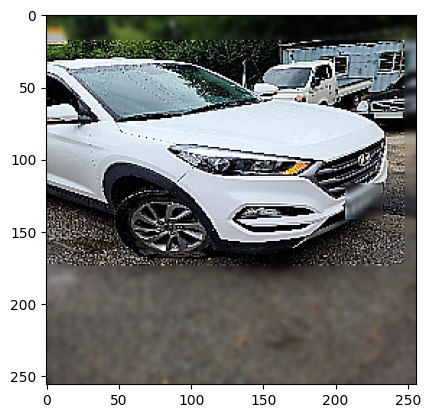

In [ ]:
plt.imshow(Xbr_processed[12])

In [ ]:
np.save('Xbr_bl_sh.npy', Xbr_processed)
np.save('Xbr_sh.npy', Xbr_new2)
np.save('Xbr_bl.npy', Xbr_new)